In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from dataclasses import dataclass, field
from abc import ABC, abstractmethod
from collections.abc import Iterable
import sys
sys.path.append("/home/hd/hd_hd/hd_gu452/oc-guidance/models")
sys.path.append("/home/hd/hd_hd/hd_gu452/oc-guidance/")
from guided_diffusion import create_model, create_model_and_diffusion, model_and_diffusion_defaults
from utils.degredations import build_degredation_model
from utils.functions import sigmoid, get_timesteps
# load and show test_image.png
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
from math import prod
from tqdm.auto import tqdm, trange
from torch.utils.data import DataLoader
from fff import FiberModel
from tqdm.auto import tqdm
import argparse
import json
import tempfile
import random
import types

import monai
from monai.apps import download_url
from monai.config import print_config
from monai.transforms import LoadImage, Orientation
from monai.utils import set_determinism
from monai.inferers.inferer import SlidingWindowInferer
from monai.networks.schedulers import RFlowScheduler
from monai.data import MetaTensor
from monai.utils.type_conversion import convert_to_tensor

from monai_utils.sample import LDMSampler, ReconModel, check_input, ldm_conditional_sample_one_mask, filter_mask_with_organs
from monai_utils.utils import define_instance, dynamic_infer, binarize_labels
from monai_utils.utils_plot import find_label_center_loc, get_xyz_plot, show_image
from monai_utils.diff_model_setting import setup_logging
from monai_utils.find_masks import find_masks
from monai_utils.augmentation import augmentation

device = "cuda" if torch.cuda.is_available() else "cpu"

/home/hd/hd_hd/hd_gu452/miniconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO: Using pytorch backend
2025-08-25 14:04:59.031712: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-25 14:04:59.031793: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-25 14:04:59.033767: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-25 14:04:59.124214: I tensorflow/core/platfo

# Code from the inference tutorial

In [2]:
model_def_path = "./configs/config_maisi3d-rflow.json"
with open(model_def_path, "r") as f:
    model_def = json.load(f)

In [3]:
os.environ["MONAI_DATA_DIRECTORY"] = "."
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory

In [4]:
files = [
    {
        "path": "models/autoencoder_epoch273.pt",
        "url": "https://developer.download.nvidia.com/assets/Clara/monai/tutorials"
        "/model_zoo/model_maisi_autoencoder_epoch273_alternative.pt",
    },
    {
        "path": "models/mask_generation_autoencoder.pt",
        "url": "https://developer.download.nvidia.com/assets/Clara/monai" "/tutorials/mask_generation_autoencoder.pt",
    },
    {
        "path": "models/mask_generation_diffusion_unet.pt",
        "url": "https://developer.download.nvidia.com/assets/Clara/monai"
        "/tutorials/model_zoo/model_maisi_mask_generation_diffusion_unet_v2.pt",
    },
    {
        "path": "configs/all_anatomy_size_condtions.json",
        "url": "https://developer.download.nvidia.com/assets/Clara/monai/tutorials/all_anatomy_size_condtions.json",
    },
    {
        "path": "datasets/all_masks_flexible_size_and_spacing_4000.zip",
        "url": "https://developer.download.nvidia.com/assets/Clara/monai"
        "/tutorials/all_masks_flexible_size_and_spacing_4000.zip",
    },
    {
        "path": "models/diff_unet_3d_rflow.pt",
        "url": "https://developer.download.nvidia.com/assets/Clara/monai/tutorials/"
        "diff_unet_ckpt_rflow_epoch19350.pt",
    },
    {
        "path": "models/controlnet_3d_rflow.pt",
        "url": "https://developer.download.nvidia.com/assets/Clara/monai/tutorials/controlnet_rflow_epoch60.pt",
    },
    {
        "path": "configs/candidate_masks_flexible_size_and_spacing_4000.json",
        "url": "https://developer.download.nvidia.com/assets/Clara/monai"
        "/tutorials/candidate_masks_flexible_size_and_spacing_4000.json",
    },
]

for file in files:
    file["path"] = file["path"] if "datasets/" not in file["path"] else os.path.join(root_dir, file["path"])
    download_url(url=file["url"], filepath=file["path"])


2025-08-22 16:22:08,148 - INFO - Expected md5 is None, skip md5 check for file models/autoencoder_epoch273.pt.
2025-08-22 16:22:08,148 - INFO - File exists: models/autoencoder_epoch273.pt, skipped downloading.
2025-08-22 16:22:08,149 - INFO - Expected md5 is None, skip md5 check for file models/mask_generation_autoencoder.pt.
2025-08-22 16:22:08,149 - INFO - File exists: models/mask_generation_autoencoder.pt, skipped downloading.
2025-08-22 16:22:08,150 - INFO - Expected md5 is None, skip md5 check for file models/mask_generation_diffusion_unet.pt.
2025-08-22 16:22:08,150 - INFO - File exists: models/mask_generation_diffusion_unet.pt, skipped downloading.
2025-08-22 16:22:08,151 - INFO - Expected md5 is None, skip md5 check for file configs/all_anatomy_size_condtions.json.
2025-08-22 16:22:08,151 - INFO - File exists: configs/all_anatomy_size_condtions.json, skipped downloading.
2025-08-22 16:22:08,152 - INFO - Expected md5 is None, skip md5 check for file datasets/all_masks_flexible_s

In [5]:
args = argparse.Namespace()

environment_file = "./configs/environment_maisi3d-rflow.json"

with open(environment_file, "r") as f:
    env_dict = json.load(f)
for k, v in env_dict.items():
    # Update the path to the downloaded dataset in MONAI_DATA_DIRECTORY
    val = v if "datasets/" not in v else os.path.join(root_dir, v)
    setattr(args, k, val)
    print(f"{k}: {val}")
print("Global config variables have been loaded.")

output_dir: output
trained_autoencoder_path: models/autoencoder_epoch273.pt
trained_diffusion_path: models/diff_unet_3d_rflow.pt
trained_controlnet_path: models/controlnet_3d_rflow.pt
trained_mask_generation_autoencoder_path: models/mask_generation_autoencoder.pt
trained_mask_generation_diffusion_path: models/mask_generation_diffusion_unet.pt
all_mask_files_base_dir: ./datasets/all_masks_flexible_size_and_spacing_4000
all_mask_files_json: ./configs/candidate_masks_flexible_size_and_spacing_4000.json
all_anatomy_size_conditions_json: ./configs/all_anatomy_size_condtions.json
label_dict_json: ./configs/label_dict.json
label_dict_remap_json: ./configs/label_dict_124_to_132.json
Global config variables have been loaded.


In [6]:
with open(model_def_path, "r") as f:
    model_def = json.load(f)
for k, v in model_def.items():
    setattr(args, k, v)

# check the format of inference inputs
config_infer_file = "./configs/config_infer_8g_256x256x128.json"
with open(config_infer_file, "r") as f:
    config_infer_dict = json.load(f)
for k, v in config_infer_dict.items():
    setattr(args, k, v)
    print(f"{k}: {v}")

check_input(
    args.body_region,
    args.anatomy_list,
    args.label_dict_json,
    args.output_size,
    args.spacing,
    args.controllable_anatomy_size,
)
latent_shape = [args.latent_channels, args.output_size[0] // 4, args.output_size[1] // 4, args.output_size[2] // 4]
print("Network definition and inference inputs have been loaded.")

INFO: `controllable_anatomy_size` is empty.
We will synthesize based on `body_region`: (['chest']) and `anatomy_list`: (['lung tumor']).
INFO: The generate results will have voxel size to be [1.5, 1.5, 4.0]mm, volume size to be [256, 256, 128].


num_output_samples: 1
body_region: ['chest']
anatomy_list: ['lung tumor']
controllable_anatomy_size: []
num_inference_steps: 30
mask_generation_num_inference_steps: 1000
output_size: [256, 256, 128]
image_output_ext: .nii.gz
label_output_ext: .nii.gz
spacing: [1.5, 1.5, 4.0]
autoencoder_sliding_window_infer_size: [16, 16, 16]
autoencoder_sliding_window_infer_overlap: 0.6666
autoencoder_tp_num_splits: 12
controlnet: $@controlnet_def
diffusion_unet: $@diffusion_unet_def
autoencoder: $@autoencoder_def
mask_generation_autoencoder: $@mask_generation_autoencoder_def
mask_generation_diffusion: $@mask_generation_diffusion_def
modality: 1
Network definition and inference inputs have been loaded.


In [7]:
noise_scheduler = define_instance(args, "noise_scheduler")
mask_generation_noise_scheduler = define_instance(args, "mask_generation_noise_scheduler")

device = torch.device("cuda")

autoencoder = define_instance(args, "autoencoder_def").to(device)
checkpoint_autoencoder = torch.load(args.trained_autoencoder_path, weights_only=True)
autoencoder.load_state_dict(checkpoint_autoencoder)

diffusion_unet = define_instance(args, "diffusion_unet_def").to(device)
checkpoint_diffusion_unet = torch.load(args.trained_diffusion_path, weights_only=False)
diffusion_unet.load_state_dict(checkpoint_diffusion_unet["unet_state_dict"], strict=True)
scale_factor = checkpoint_diffusion_unet["scale_factor"].to(device)

controlnet = define_instance(args, "controlnet_def").to(device)
checkpoint_controlnet = torch.load(args.trained_controlnet_path, weights_only=False)
monai.networks.utils.copy_model_state(controlnet, diffusion_unet.state_dict())
controlnet.load_state_dict(checkpoint_controlnet["controlnet_state_dict"], strict=True)

mask_generation_autoencoder = define_instance(args, "mask_generation_autoencoder_def").to(device)
checkpoint_mask_generation_autoencoder = torch.load(args.trained_mask_generation_autoencoder_path, weights_only=True)
mask_generation_autoencoder.load_state_dict(checkpoint_mask_generation_autoencoder)

mask_generation_diffusion_unet = define_instance(args, "mask_generation_diffusion_def").to(device)
checkpoint_mask_generation_diffusion_unet = torch.load(args.trained_mask_generation_diffusion_path, weights_only=True)
mask_generation_diffusion_unet.load_state_dict(checkpoint_mask_generation_diffusion_unet["unet_state_dict"])
mask_generation_scale_factor = checkpoint_mask_generation_diffusion_unet["scale_factor"]

print("All the trained model weights have been loaded.")

2025-08-12 18:53:20,849 - INFO - 'dst' model updated: 180 of 231 variables.
All the trained model weights have been loaded.


In [8]:
set_determinism(seed=0)
args.random_seed = 0

In [9]:
ldm_sampler = LDMSampler(
    args.body_region,
    args.anatomy_list,
    args.all_mask_files_json,
    args.all_anatomy_size_conditions_json,
    args.all_mask_files_base_dir,
    args.label_dict_json,
    args.label_dict_remap_json,
    autoencoder,
    diffusion_unet,
    controlnet,
    noise_scheduler,
    scale_factor,
    mask_generation_autoencoder,
    mask_generation_diffusion_unet,
    mask_generation_scale_factor,
    mask_generation_noise_scheduler,
    device,
    latent_shape,
    args.mask_generation_latent_shape,
    args.output_size,
    args.output_dir,
    args.controllable_anatomy_size,
    image_output_ext=args.image_output_ext,
    label_output_ext=args.label_output_ext,
    spacing=args.spacing,
    modality=args.modality,
    num_inference_steps=args.num_inference_steps,
    mask_generation_num_inference_steps=args.mask_generation_num_inference_steps,
    random_seed=args.random_seed,
    autoencoder_sliding_window_infer_size=args.autoencoder_sliding_window_infer_size,
    autoencoder_sliding_window_infer_overlap=args.autoencoder_sliding_window_infer_overlap,
)

INFO: LDM sampler initialized.


In [10]:
with torch.no_grad():
    output_filenames = ldm_sampler.sample_multiple_images(args.num_output_samples)

augmenting lung tumor
30
metatensor(7854., device='cuda:0') | metatensor(7704.4004, device='cuda:0')


100%|███████████████████████████████████████████████████████████████| 605/605 [00:58<00:00, 10.28it/s]


1 5
augmenting lung tumor
28
metatensor(1016., device='cuda:0') | metatensor(1327.7001, device='cuda:0')
metatensor(728., device='cuda:0') | metatensor(1327.7001, device='cuda:0')
metatensor(1035., device='cuda:0') | metatensor(1327.7001, device='cuda:0')
metatensor(626., device='cuda:0') | metatensor(1327.7001, device='cuda:0')
metatensor(0., device='cuda:0') | metatensor(1327.7001, device='cuda:0')
metatensor(150., device='cuda:0') | metatensor(1327.7001, device='cuda:0')
metatensor(1081., device='cuda:0') | metatensor(1327.7001, device='cuda:0')
metatensor(1113., device='cuda:0') | metatensor(1327.7001, device='cuda:0')
metatensor(0., device='cuda:0') | metatensor(1327.7001, device='cuda:0')
metatensor(0., device='cuda:0') | metatensor(1327.7001, device='cuda:0')
metatensor(1815., device='cuda:0') | metatensor(1327.7001, device='cuda:0')


100%|███████████████████████████████████████████████████████████████| 605/605 [01:00<00:00, 10.02it/s]


1 4
2025-08-12 10:53:17,543 INFO image_writer.py:197 - writing: output/sample_20250812_105317_532910_image.nii.gz
2025-08-12 10:53:18,079 INFO image_writer.py:197 - writing: output/sample_20250812_105317_532910_label.nii.gz


Visualizing output/sample_20250812_105317_532910_image.nii.gz and output/sample_20250812_105317_532910_label.nii.gz...


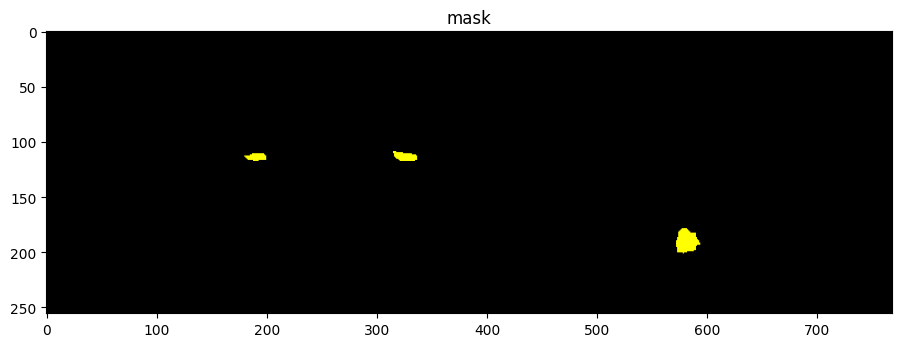

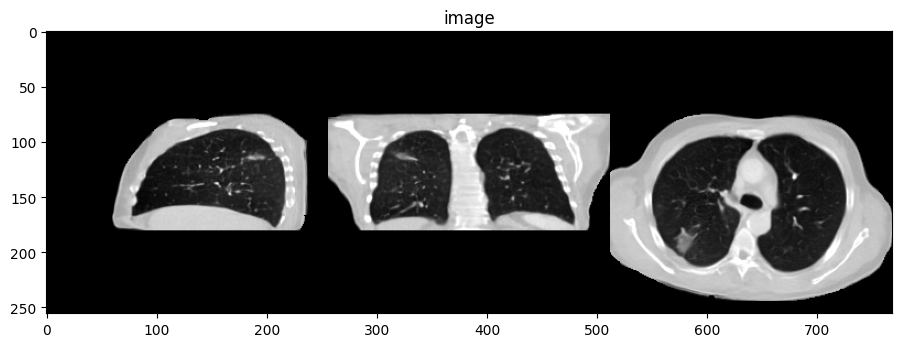

In [12]:
visualize_image_filename = output_filenames[0][0]
visualize_mask_filename = output_filenames[0][1]
print(f"Visualizing {visualize_image_filename} and {visualize_mask_filename}...")

# load image/mask pairs
loader = LoadImage(image_only=True, ensure_channel_first=True)
orientation = Orientation(axcodes="RAS")
image_volume = orientation(loader(visualize_image_filename))
mask_volume = orientation(loader(visualize_mask_filename)).to(torch.uint8)

# visualize for CT HU intensity between [-200, 500]
image_volume = torch.clip(image_volume, -1000, 300)
image_volume = image_volume - torch.min(image_volume)
image_volume = image_volume / torch.max(image_volume)

# create a random color map for mask visualization
colorize = torch.clip(torch.cat([torch.zeros(3, 1, 1, 1), torch.randn(3, 200, 1, 1)], 1), 0, 1)
target_class_index = 1

# find center voxel location for 2D slice visualization
center_loc_axis = find_label_center_loc(torch.flip(mask_volume[0, ...] == target_class_index, [-3, -2, -1]))

# visualization
vis_mask = get_xyz_plot(
    mask_volume, center_loc_axis, mask_bool=True, n_label=201, colorize=colorize, target_class_index=target_class_index
)
show_image(vis_mask, title="mask")

vis_image = get_xyz_plot(image_volume, center_loc_axis, mask_bool=False)
show_image(vis_image, title="image")

# NDTM Integration

In [2]:
class FlowMatchingModel:
    def __init__(self, ldm_sampler, resize_label=False):
        self.ldm_sampler = ldm_sampler
        self.recon_model = ReconModel(ldm_sampler.autoencoder, ldm_sampler.scale_factor)
        self.inferer = SlidingWindowInferer(
            roi_size=ldm_sampler.autoencoder_sliding_window_infer_size,
            sw_batch_size=1,
            progress=False,
            mode="gaussian",
            overlap=ldm_sampler.autoencoder_sliding_window_infer_overlap,
            sw_device=device,
            device=torch.device("cpu"),
        )
        self.include_modality = ldm_sampler.diffusion_unet.num_class_embeds is not None
        self.include_body_region = ldm_sampler.diffusion_unet.include_top_region_index_input
        self.resize_label=resize_label

    def get_label_tensor(self, **kwargs):
        combine_label_tensor = kwargs.get('combine_label_tensor', None)
        if combine_label_tensor is not None:
            combine_label = combine_label_tensor.to(device)
            if (
                self.ldm_sampler.output_size[0] != combine_label.shape[2]
                or self.ldm_sampler.output_size[1] != combine_label.shape[3]
                or self.ldm_sampler.output_size[2] != combine_label.shape[4]
            ) and self.resize_label:
                combine_label = torch.nn.functional.interpolate(combine_label, size=self.ldm_sampler.output_size, mode="nearest")
            
            return combine_label
        else:
            return None
    
    
    def __call__(self, xt, y, t, **kwargs):
        """
        Forward pass through the flow matching model.
        :param xt: Current state (image).
        :param y: Condition (e.g., class label).
        :param t: Current timestep.
        :param kwargs: Additional arguments.
        :return: Estimated noise or flow at xt.
        """
        combine_label = self.get_label_tensor(**kwargs)
        if combine_label is not None:
            controlnet_cond_vis = binarize_labels(combine_label.as_tensor().long()).float()
            
            controlnet_inputs = {
                'x': xt,
                'timesteps': torch.Tensor((t,)).to(device).float(),
                'controlnet_cond': controlnet_cond_vis,
            }
            if self.include_modality:
                controlnet_inputs['class_labels'] = kwargs.get('modality_tensor', None)
            down_block_res_samples, mid_block_res_sample = self.ldm_sampler.controlnet(**controlnet_inputs)
        else:
            down_block_res_samples = None
            mid_block_res_sample = None
            
        unet_inputs = {
            "x": xt,
            "timesteps": torch.Tensor((t,)).to(device).float(),
            "spacing_tensor": kwargs.get('spacing_tensor', None),
            "down_block_additional_residuals": down_block_res_samples,
            "mid_block_additional_residual": mid_block_res_sample,
        }
        if self.include_body_region:
            unet_inputs['top_region_index_tensor'] = kwargs.get('top_region_index_tensor', None)
            unet_inputs['bottom_region_index_tensor'] = kwargs.get('bottom_region_index_tensor', None)
        if self.include_modality:
            unet_inputs['class_labels'] = kwargs.get('modality_tensor', None)
        return self.ldm_sampler.diffusion_unet(**unet_inputs)

    @property
    def latent_dim(self):
        """
        Returns the latent dimension of the model.
        :return: Latent dimension.
        """
        return prod(self.ldm_sampler.latent_shape)

    @property
    def latent_shape(self):
        """
        Returns the shape of the latent representation.
        :return: Latent shape as a tuple.
        """
        return self.ldm_sampler.latent_shape
    
    def decode(self, x, y, **kwargs):
        """
        Decode the latent representation to an image.
        :param x: Latent representation.
        :return: Decoded image.
        """
        # CT image intensity range
        a_min = -1000
        a_max = 1000
        # autoencoder output intensity range
        b_min = 0.0
        b_max = 1
        # decode latent representation to synthetic images
        synthetic_images = dynamic_infer(self.inferer, self.recon_model, x.float()).float()
        synthetic_images = (synthetic_images - b_min) / (b_max - b_min)
        # project output to [-1000, 1000]
        synthetic_images = synthetic_images * (a_max - a_min) + a_min
        # regularize background intensities
        combine_label = self.get_label_tensor(**kwargs)
        # crop non-body regions
        synthetic_images[combine_label == 0] = -1000
        torch.cuda.empty_cache()
        return synthetic_images


In [3]:
class Combine_fn(ABC):
    def __init__(self, gamma_t=None):
        self.gamma_t = gamma_t

    @abstractmethod
    def forward(self, xt, ut, t=None, **kwargs):
        pass

    def __call__(self, xt, ut, t=None, **kwargs):
        return self.forward(xt, ut, t=t, **kwargs)


class Additive(Combine_fn):
    def forward(self, xt, ut, t=None, **kwargs):
        gamma_t = self.gamma_t(t) if callable(self.gamma_t) else self.gamma_t
        return xt + (gamma_t * ut if gamma_t is not None else ut)

@dataclass
class NDTMConfig:
    N: int = 2  # Number of optimization steps
    gamma_t: float = 4.0  # u_t weight
    u_lr: float = 0.01  # learning rate for u_t
    combine_fn: str = "additive"  # Function to combine vfs
    w_vf_scheme: str = "zeros"  # Weighting scheme for vf
    w_control_scheme: str = "zeros"  # Weighting scheme for vf
    u_lr_scheduler: str = "linear"  # Learning rate scheduler for u_t
    init_control: str = "zero"  # Initialization scheme for u_t
    init_xT: str = "random" # Initialization scheme for x_T
    w_terminal: float = 50.0
    clip_images: bool = True  # If True, clip images
    clip_range: list = field(default_factory=lambda: [-1, 1])  # Range to clip images
    pred_each_step: bool = True  # If True, predict x0 at each step
    noise_scheduler: RFlowScheduler = field(default_factory=lambda: RFlowScheduler(
        num_train_timesteps=1000,
        beta_start=0.0001,
        beta_end=0.02,
        beta_schedule="linear",
        prediction_type="epsilon",
        rescale_betas_zero_snr=False,
    ))
    patch_size: list | int | None = None

class NDTM:
    def __init__(self, generative_model, subject_model, hparams):
        self.generative_model = generative_model
        self.subject_model = subject_model
        self.hparams = hparams
        self.F = self._get_combine_fn()

    def _get_combine_fn(self):
        if self.hparams.combine_fn == "additive":
            return Additive(gamma_t=self.hparams.gamma_t)

    def _get_vf_weight(self, scheme):
        if scheme == "zero":
            return torch.tensor([0.0], device=device)
        # also the "FM" scheme, since it has constant velocity
        elif scheme == "ones":
            return torch.tensor([1.0], device=device) * 1.e-4
        else:
            raise ValueError(f"Unknown scheme: {scheme}")

    def _get_control_weight(self, scheme):
        if scheme == "zero":
            return torch.tensor([0.0], device=device)
        elif scheme == "ones":
            return torch.tensor([1.0], device=device) * 1.e-4
        else:
            raise ValueError(f"Unknown scheme: {scheme}")

    def get_learning_rate(self, base_lr, current_step, total_steps):
        assert self.hparams.u_lr_scheduler in ["linear", "const"], \
            f"Unknown learning rate scheduler: {self.hparams.u_lr_scheduler}"
        
        if self.hparams.u_lr_scheduler == "linear":
            return base_lr * (1.0 - current_step / total_steps)
        else:  # const
            return base_lr

    def get_random_patch_indices(self, full_size):
        if self.hparams.patch_size is None:
            patch_size = full_size
        else:
            patch_size = self.hparams.patch_size
        if not isinstance(patch_size, Iterable):
            patch_size = tuple([patch_size for _ in range(len(full_size))])
        if any([p > f for p, f in zip(patch_size, full_size)]):
            raise ValueError(f"Patchsize {patch_size} is larger than full image size {full_size} in at least one dimensions")
        ind = []
        for dim in range(len(full_size)):
            upper = random.randint(0, full_size[dim] - patch_size[dim])
            lower = upper + patch_size[dim]
            ind.append((upper, lower))
        return ind
        # return [(24, 24+patch_size[0]), (24, 24+patch_size[1]), (8, 8+patch_size[2])]
    
    def sample(self, x, y, num_timesteps=100, **kwargs):
        x_orig = x.clone()
        x = self.initialize(x, y, num_timesteps, **kwargs)
        y_0 = kwargs["y_0"]
        bs = x.size(0)
        xt = x
        xt_s = [xt.cpu()]
        x0_s = []
        uts = []        
        u_t = torch.zeros_like(xt)
        noise_scheduler.set_timesteps(
            num_inference_steps=num_timesteps,
            input_img_size_numel=prod(self.generative_model.latent_shape[1:]),
        )
        ts = noise_scheduler.timesteps
        ts_next = torch.cat((ts[1:], torch.tensor([0], dtype=ts.dtype)))
        pbar = tqdm(zip(ts, ts_next), desc="Sampling", total=num_timesteps)
        for i, (ti, ti_next) in enumerate(pbar):

            t = torch.ones(bs).to(x.device).long() * ti
            t_next = torch.ones(bs).to(x.device).long() * ti_next

            # Initialize control and the optimizer
            u_t = self.initialize_ut(u_t, i)
            ut_clone = u_t.clone().detach()
            ut_clone.requires_grad = True
            current_lr = self.get_learning_rate(self.hparams.u_lr, i, num_timesteps)
            optimizer = torch.optim.Adam([ut_clone], lr=current_lr)

            # Loss weightings
            w_terminal = self.hparams.w_terminal
            w_vf = self._get_vf_weight(self.hparams.w_vf_scheme)
            w_control = self._get_control_weight(self.hparams.w_control_scheme)
            
            ####################################################
            ############## Control Optimization ################
            ####################################################
            vt = self.generative_model(xt, y, t, **kwargs).detach()
            patch_ind_latent = self.get_random_patch_indices(self.generative_model.latent_shape[1:])
            patch_ind_img = [(p[0] * 4, p[1] * 4) for p in patch_ind_latent]
            for _ in range(self.hparams.N):
                if callable(self.hparams.gamma_t):
                    gamma_t = self.hparams.gamma_t(t)
                else:
                    gamma_t = self.hparams.gamma_t
                if gamma_t == 0:
                    break
                with torch.cuda.amp.autocast(enabled=False):

                    # Guided state vector
                    cxt = self.F(xt, ut_clone, t=t, **kwargs)
                    # Unguided and guided noise estimates
                    vt_control = self.generative_model(cxt, y, t, **kwargs)
                    c_vf = w_vf * ((vt_control - vt) ** 2).reshape(bs, -1).sum(dim=1)
                    # Control loss
                    control_loss = (((self.F(xt, ut_clone, t=t, **kwargs) - xt) ** 2).reshape(bs, -1).sum(dim=1))
                    c_control = w_control * control_loss * (gamma_t**2)
    
                    # Terminal Cost
                    # c_terminal = ((y_0 - self.subject_model(x0_pred)) ** 2).reshape(bs, -1).sum(dim=1)
                    x0_latent = cxt + (ti/1000) * vt_control
                    x0_latent = x0_latent[..., patch_ind_latent[0][0]:patch_ind_latent[0][1], patch_ind_latent[1][0]:patch_ind_latent[1][1], patch_ind_latent[2][0]:patch_ind_latent[2][1]]
                    old_combine_label_tensor = kwargs.get('combine_label_tensor', None)
                    if old_combine_label_tensor is not None:
                        combine_label_tensor = torch.as_tensor(old_combine_label_tensor).detach().requires_grad_(False)
                        kwargs["combine_label_tensor"] = combine_label_tensor[..., patch_ind_img[0][0]:patch_ind_img[0][1], patch_ind_img[1][0]:patch_ind_img[1][1], patch_ind_img[2][0]:patch_ind_img[2][1]]
                    x0_pred = self.generative_model.decode(x0_latent, y, **kwargs)
                    if old_combine_label_tensor is not None:
                        kwargs["combine_label_tensor"] = old_combine_label_tensor
                    if self.hparams.clip_images:
                        x0_pred = torch.clamp(x0_pred, self.hparams.clip_range[0], self.hparams.clip_range[1])
                    y_patch = y_0[..., patch_ind_img[0][0]:patch_ind_img[0][1], patch_ind_img[1][0]:patch_ind_img[1][1], patch_ind_img[2][0]:patch_ind_img[2][1]]
                    c_terminal = torch.abs(y_patch - self.subject_model(x0_pred)).reshape(bs, -1).mean(dim=1)
                    c_terminal = w_terminal * c_terminal
                    # Aggregate Cost and optimize
                    c_t = c_vf + c_control + c_terminal
    
                    # print(
                    #     f"Diffusion step: {ti} Terminal Loss: {c_terminal.mean().item()} "
                    #     f"Control loss: {c_control.mean().item()} vf loss: {c_vf.mean().item()}"
                    # )
                    
    
                    optimizer.zero_grad()
                    c_t.sum().backward()
                    # torch.nn.utils.clip_grad_norm_(ut_clone, 1.0)
                    optimizer.step()
                if self.hparams.N > 0 and gamma_t != 0:
                    pbar.set_description(
                        f"Diffusion step: {ti} Terminal Loss: {c_terminal.mean().item()} "
                        f"Control loss: {c_control.mean().item()} vf loss: {c_vf.mean().item()}"
                    )
            ###########################################
            ############## DDIM update ################
            ###########################################
            with torch.no_grad():

                u_t = ut_clone.detach()
                cxt = self.F(xt, u_t, t=t, **kwargs)
                
                vt_control = self.generative_model(cxt, y, t, **kwargs)
                if self.hparams.pred_each_step:
                    x0_pred = self.generative_model.decode(cxt + (ti/1000) * vt_control, y, **kwargs)
                    if self.hparams.clip_images:
                        x0_pred = torch.clamp(x0_pred, self.hparams.clip_range[0], self.hparams.clip_range[1])
                    x0_s.append(x0_pred.cpu())
                step_size = (t - t_next)/1000
                xt = cxt + step_size * vt_control

                uts.append(u_t.cpu())

            xt_s.append(xt.cpu())

        with torch.no_grad():
            final_output = self.generative_model.decode(xt_s[-1].to(device), y, **kwargs).cpu()
        return final_output, list(reversed(xt_s)), list(reversed(x0_s))

    def initialize_ut(self, ut, i):
        init_control = self.hparams.init_control

        if init_control == "zero":  # constant zero
            return torch.zeros_like(ut)
        elif init_control == "random":  # constant random
            return torch.randn_like(ut)
    
        elif "causal" in init_control:
            if "zero" in init_control and i == 0:  # causal_zero
                return torch.zeros_like(ut)
            elif "random" in init_control and i == 0:  # causal_random
                return torch.randn_like(ut)

            else:
                return ut

    def initialize(self, x, y, num_timesteps, **kwargs):
        """
        random: Initialization with x_T ~ N(0, 1)
        guided: Initialization with x_T ~ DDPM(H^(y_0)) - Only for Linear IP
        """
        init_scheme = self.hparams.init_xT
        
        if init_scheme == "guided":
            raise(NotImplementedError("Guided initialization not implemented (could be useful if subject model decoder is available)"))
        else:
            return torch.randn(x.shape[0], *self.generative_model.latent_shape, device=x.device, dtype=x.dtype)


# Gaussian Blur Subject Model

In [4]:
import torch
import torch.nn as nn
from collections import defaultdict

SENSITIVE_TYPES = (
    nn.Conv1d, nn.Conv2d, nn.Conv3d,
    nn.Linear,
    nn.GroupNorm, nn.LayerNorm,
    nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d, nn.AvgPool3d
)

def _cast_tensor_to_dtype(t: torch.Tensor, dtype: torch.dtype):
    if t is None:
        return None
    return t.detach().to(device=t.device, dtype=dtype)

def make_fp32_island(module: nn.Module):
    """
    Wrap module.forward so parameters/buffers are temporarily replaced by fp32 copies
    for the duration of the forward call. Restores originals afterwards.
    NOTE: This assumes you are NOT training the module's parameters (they should be frozen).
    """
    orig_forward = module.forward

    def wrapped_forward(*args, **kwargs):
        # find caller dtype from first tensor arg
        caller_dtype = None
        for a in list(args) + list(kwargs.values()):
            if isinstance(a, torch.Tensor):
                caller_dtype = a.dtype
                break
        if caller_dtype is None:
            caller_dtype = torch.float16  # default

        # Save originals
        saved_params = {}
        saved_buffers = {}

        # Replace parameters with fp32 copies (as nn.Parameter)
        for name, param in list(module._parameters.items()):
            if param is None:
                continue
            saved_params[name] = param
            # create a detached Parameter copy in fp32
            p32 = nn.Parameter(_cast_tensor_to_dtype(param, torch.float32), requires_grad=False)
            module._parameters[name] = p32

        # Replace buffers with fp32 copies
        for name, buf in list(module._buffers.items()):
            if buf is None:
                continue
            saved_buffers[name] = buf
            module._buffers[name] = _cast_tensor_to_dtype(buf, torch.float32)

        # Cast inputs to fp32 (contiguous), run forward without autocast
        def _cast_args_kwargs(args, kwargs):
            args32 = tuple(a.to(dtype=torch.float32).contiguous() if isinstance(a, torch.Tensor) else a for a in args)
            kwargs32 = {k: (v.to(dtype=torch.float32).contiguous() if isinstance(v, torch.Tensor) else v) for k, v in kwargs.items()}
            return args32, kwargs32

        args32, kwargs32 = _cast_args_kwargs(args, kwargs)

        try:
            with torch.cuda.amp.autocast(enabled=False):
                out32 = orig_forward(*args32, **kwargs32)
        finally:
            # Restore everything even if forward raises
            for name, param in saved_params.items():
                module._parameters[name] = param
            for name, buf in saved_buffers.items():
                module._buffers[name] = buf

        # Cast outputs back to caller dtype
        def _cast_back(out):
            if isinstance(out, torch.Tensor):
                return out.to(caller_dtype).contiguous()
            if isinstance(out, (tuple, list)):
                return type(out)(_cast_back(o) if isinstance(o, torch.Tensor) else o for o in out)
            if isinstance(out, dict):
                return {k: (_cast_back(v) if isinstance(v, torch.Tensor) else v) for k, v in out.items()}
            return out

        return _cast_back(out32)

    module.forward = wrapped_forward
    return module

def patch_fp32_islands(model: nn.Module):
    """
    Wrap all SENSITIVE_TYPES in model with fp32 islands.
    Skip wrapping if a module has shared parameters (can't safely swap in that case).
    """
    # Count parameter object occurrences across the whole model (to detect sharing).
    param_counts = defaultdict(int)
    for p in model.parameters():
        param_counts[id(p)] += 1

    wrapped_modules = []
    for m in model.modules():
        if isinstance(m, SENSITIVE_TYPES):
            # check for shared parameters in this module
            shared = False
            for p in m._parameters.values():
                if p is None:
                    continue
                if param_counts.get(id(p), 0) > 1:
                    shared = True
                    break
            if shared:
                print(f"[patch_fp32_islands] skipping wrap for {m} because it has shared parameters.")
                continue

            # warn if param.requires_grad True (we're replacing with non-updated fp32 copies)
            for p in m._parameters.values():
                if p is not None and p.requires_grad:
                    print(f"[patch_fp32_islands] WARNING: module {m} has parameter.requires_grad=True."
                          " This patch will not propagate grads back to the original param.")
                    break

            make_fp32_island(m)
            wrapped_modules.append(m)

    print(f"[patch_fp32_islands] wrapped {len(wrapped_modules)} modules.")
    return wrapped_modules


def safe_backward_hook(module, grad_input, grad_output):
    # Clone/detach to avoid inplace/view issues
    safe_grad_input = tuple(
        g.clone().detach() if g is not None else None
        for g in grad_input
    )
    safe_grad_output = tuple(
        g.clone().detach() if g is not None else None
        for g in grad_output
    )

    # Now you can run diagnostics on safe_grad_input/output
    for i, g in enumerate(safe_grad_input):
        if g is not None and not torch.all(torch.isfinite(g)):
            print(f"[NaN/Inf] in grad_input[{i}] of {module.__class__.__name__}")

    for i, g in enumerate(safe_grad_output):
        if g is not None and not torch.all(torch.isfinite(g)):
            print(f"[NaN/Inf] in grad_output[{i}] of {module.__class__.__name__}")

    # Return grad_input unchanged (so autograd still works)
    return grad_input


def attach_safe_hooks(model):
    hooks = []
    for module in model.modules():
        # only attach to leaf modules or ones you care about
        hooks.append(module.register_full_backward_hook(safe_backward_hook))
    return hooks

def patch_unet_down_blocks(unet):
    """
    Safely patch the _apply_down_blocks method of a diffusion UNet to avoid
    inplace modifications on views, which can break autograd when backward hooks are used.
    """
    # Define a safe wrapper
    def safe_apply_down_blocks(self, h, emb, context, down_block_additional_residuals):
        if context is not None and self.with_conditioning is False:
            raise ValueError("model should have with_conditioning = True if context is provided")
        down_block_res_samples: list[torch.Tensor] = [h]
        for downsample_block in self.down_blocks:
            h, res_samples = downsample_block(hidden_states=h, temb=emb, context=context)
            down_block_res_samples.extend(res_samples)

        # Additional residual conections for Controlnets
        if down_block_additional_residuals is not None:
            new_down_block_res_samples: list[torch.Tensor] = []
            for down_block_res_sample, down_block_additional_residual in zip(
                down_block_res_samples, down_block_additional_residuals
            ):
                down_block_res_sample = down_block_res_sample + down_block_additional_residual
                new_down_block_res_samples.append(down_block_res_sample)

            down_block_res_samples = new_down_block_res_samples
        return h, down_block_res_samples

    # Bind the safe wrapper to the UNet instance
    unet._apply_down_blocks = types.MethodType(safe_apply_down_blocks, unet)

def patch_unet_forward(unet):

    def safe_forward(
        self,
        x: torch.Tensor,
        timesteps: torch.Tensor,
        context: torch.Tensor | None = None,
        class_labels: torch.Tensor | None = None,
        down_block_additional_residuals: tuple[torch.Tensor] | None = None,
        mid_block_additional_residual: torch.Tensor | None = None,
        top_region_index_tensor: torch.Tensor | None = None,
        bottom_region_index_tensor: torch.Tensor | None = None,
        spacing_tensor: torch.Tensor | None = None,
    ) -> torch.Tensor:
        """
        Forward pass through the UNet model.

        Args:
            x: Input tensor of shape (N, C, SpatialDims).
            timesteps: Timestep tensor of shape (N,).
            context: Context tensor of shape (N, 1, ContextDim).
            class_labels: Class labels tensor of shape (N,).
            down_block_additional_residuals: Additional residual tensors for down blocks of shape (N, C, FeatureMapsDims).
            mid_block_additional_residual: Additional residual tensor for mid block of shape (N, C, FeatureMapsDims).
            top_region_index_tensor: Tensor representing top region index of shape (N, 4).
            bottom_region_index_tensor: Tensor representing bottom region index of shape (N, 4).
            spacing_tensor: Tensor representing spacing of shape (N, 3).

        Returns:
            A tensor representing the output of the UNet model.
        """

        emb = self._get_time_and_class_embedding(x, timesteps, class_labels)
        emb = self._get_input_embeddings(emb, top_region_index_tensor, bottom_region_index_tensor, spacing_tensor)
        h = self.conv_in(x)
        h, _updated_down_block_res_samples = self._apply_down_blocks(h, emb, context, down_block_additional_residuals)
        h = self.middle_block(h, emb, context)

        # Additional residual conections for Controlnets
        if mid_block_additional_residual is not None:
            h = h + mid_block_additional_residual

        h = self._apply_up_blocks(h, emb, context, _updated_down_block_res_samples)
        h = self.out(h)
        h_tensor: torch.Tensor = convert_to_tensor(h)
        return h_tensor
    
    unet.forward = types.MethodType(safe_forward, unet)

def patch_fp16_cast_autoencoder(autoencoder):
    for m in autoencoder.modules():
        if hasattr(m, "norm_float16"):
            m.norm_float16 = False
            


In [13]:
model_def_path = "./configs/config_maisi3d-rflow.json"
with open(model_def_path, "r") as f:
    model_def = json.load(f)

os.environ["MONAI_DATA_DIRECTORY"] = "."
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory

args = argparse.Namespace()

environment_file = "./configs/environment_maisi3d-rflow.json"

with open(environment_file, "r") as f:
    env_dict = json.load(f)
for k, v in env_dict.items():
    # Update the path to the downloaded dataset in MONAI_DATA_DIRECTORY
    val = v if "datasets/" not in v else os.path.join(root_dir, v)
    setattr(args, k, val)
    print(f"{k}: {val}")
print("Global config variables have been loaded.")

with open(model_def_path, "r") as f:
    model_def = json.load(f)
for k, v in model_def.items():
    setattr(args, k, v)

# check the format of inference inputs
config_infer_file = "./configs/config_infer_head_8g_256x256x128.json"
with open(config_infer_file, "r") as f:
    config_infer_dict = json.load(f)
for k, v in config_infer_dict.items():
    setattr(args, k, v)
    print(f"{k}: {v}")

check_input(
    args.body_region,
    args.anatomy_list,
    args.label_dict_json,
    args.output_size,
    args.spacing,
    args.controllable_anatomy_size,
)
latent_shape = [args.latent_channels, args.output_size[0] // 4, args.output_size[1] // 4, args.output_size[2] // 4]
print("Network definition and inference inputs have been loaded.")

set_determinism(seed=0)
args.random_seed = 0

mask_generation_noise_scheduler = define_instance(args, "mask_generation_noise_scheduler")
noise_scheduler = define_instance(args, "noise_scheduler")

autoencoder = define_instance(args, "autoencoder_def").to(device)
checkpoint_autoencoder = torch.load(args.trained_autoencoder_path, weights_only=True)
autoencoder.load_state_dict(checkpoint_autoencoder)

diffusion_unet = define_instance(args, "diffusion_unet_def").to(device)
checkpoint_diffusion_unet = torch.load(args.trained_diffusion_path, weights_only=False)
diffusion_unet.load_state_dict(checkpoint_diffusion_unet["unet_state_dict"], strict=True)
scale_factor = checkpoint_diffusion_unet["scale_factor"].to(device)

controlnet = define_instance(args, "controlnet_def").to(device)
checkpoint_controlnet = torch.load(args.trained_controlnet_path, weights_only=False)
monai.networks.utils.copy_model_state(controlnet, diffusion_unet.state_dict())
controlnet.load_state_dict(checkpoint_controlnet["controlnet_state_dict"], strict=True)

mask_generation_autoencoder = define_instance(args, "mask_generation_autoencoder_def").to(device)
checkpoint_mask_generation_autoencoder = torch.load(args.trained_mask_generation_autoencoder_path, weights_only=True)
mask_generation_autoencoder.load_state_dict(checkpoint_mask_generation_autoencoder)

mask_generation_diffusion_unet = define_instance(args, "mask_generation_diffusion_def").to(device)
checkpoint_mask_generation_diffusion_unet = torch.load(args.trained_mask_generation_diffusion_path, weights_only=True)
mask_generation_diffusion_unet.load_state_dict(checkpoint_mask_generation_diffusion_unet["unet_state_dict"])
mask_generation_scale_factor = checkpoint_mask_generation_diffusion_unet["scale_factor"]

autoencoder = autoencoder.float()
diffusion_unet = diffusion_unet.float()
controlnet = controlnet.float()
mask_generation_autoencoder = mask_generation_autoencoder.float()
mask_generation_diffusion_unet = mask_generation_diffusion_unet.float()

total_params = 0
for param in autoencoder.parameters():
    if param.requires_grad:
        total_params += param.numel()
        param.requires_grad = False
        
for param in diffusion_unet.parameters():
    if param.requires_grad:
        total_params += param.numel()
        param.requires_grad = False
        
for param in controlnet.parameters():
    if param.requires_grad:
        total_params += param.numel()
        param.requires_grad = False
        
for param in mask_generation_autoencoder.parameters():
    if param.requires_grad:
        total_params += param.numel()
        param.requires_grad = False

for param in mask_generation_diffusion_unet.parameters():
    if param.requires_grad:
        total_params += param.numel()
        param.requires_grad = False

print(f"Made {total_params} parameters non-trainable")

patch_fp32_islands(diffusion_unet)
patch_unet_forward(diffusion_unet)
patch_unet_down_blocks(diffusion_unet)
patch_fp16_cast_autoencoder(autoencoder)


inplaces_changed = 0

for module in diffusion_unet.modules():
    if isinstance(module, torch.nn.ReLU):
        inplaces_changed += module.inplace
    if isinstance(module, torch.nn.SiLU):
        inplaces_changed += module.inplace

print(f"Found {inplaces_changed} inplace operations")

ldm_sampler = LDMSampler(
    args.body_region,
    args.anatomy_list,
    args.all_mask_files_json,
    args.all_anatomy_size_conditions_json,
    args.all_mask_files_base_dir,
    args.label_dict_json,
    args.label_dict_remap_json,
    autoencoder,
    diffusion_unet,
    controlnet,
    noise_scheduler,
    scale_factor,
    mask_generation_autoencoder,
    mask_generation_diffusion_unet,
    mask_generation_scale_factor,
    mask_generation_noise_scheduler,
    device,
    latent_shape,
    args.mask_generation_latent_shape,
    args.output_size,
    args.output_dir,
    args.controllable_anatomy_size,
    image_output_ext=args.image_output_ext,
    label_output_ext=args.label_output_ext,
    spacing=args.spacing,
    modality=args.modality,
    num_inference_steps=args.num_inference_steps,
    mask_generation_num_inference_steps=args.mask_generation_num_inference_steps,
    random_seed=args.random_seed,
    autoencoder_sliding_window_infer_size=args.autoencoder_sliding_window_infer_size,
    autoencoder_sliding_window_infer_overlap=args.autoencoder_sliding_window_infer_overlap,
)

INFO: `controllable_anatomy_size` is empty.
We will synthesize based on `body_region`: (['head']) and `anatomy_list`: ([]).
INFO: The generate results will have voxel size to be [1.5, 1.5, 4.0]mm, volume size to be [256, 256, 128].


output_dir: output
trained_autoencoder_path: models/autoencoder_epoch273.pt
trained_diffusion_path: models/diff_unet_3d_rflow.pt
trained_controlnet_path: models/controlnet_3d_rflow.pt
trained_mask_generation_autoencoder_path: models/mask_generation_autoencoder.pt
trained_mask_generation_diffusion_path: models/mask_generation_diffusion_unet.pt
all_mask_files_base_dir: ./datasets/all_masks_flexible_size_and_spacing_4000
all_mask_files_json: ./configs/candidate_masks_flexible_size_and_spacing_4000.json
all_anatomy_size_conditions_json: ./configs/all_anatomy_size_condtions.json
label_dict_json: ./configs/label_dict.json
label_dict_remap_json: ./configs/label_dict_124_to_132.json
Global config variables have been loaded.
num_output_samples: 1
body_region: ['head']
anatomy_list: []
controllable_anatomy_size: []
num_inference_steps: 30
mask_generation_num_inference_steps: 1000
output_size: [256, 256, 128]
image_output_ext: .nii.gz
label_output_ext: .nii.gz
spacing: [1.5, 1.5, 4.0]
autoencoder

INFO: LDM sampler initialized.


Made 475902358 parameters non-trainable
[patch_fp32_islands] wrapped 220 modules.
Found 0 inplace operations


In [14]:
args.body_region

['head']

In [15]:
class GaussianBlurSubjectModel(nn.Module):
    def __init__(self, kernel_size, sigma):
        """
        Initializes the GaussianBlurSubjectModel.
        
        Args:
            kernel_size (int): Size of the Gaussian kernel.
            sigma (float): Standard deviation of the Gaussian kernel.
        """
        super().__init__()
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.blur = nn.Conv3d(1, 1, kernel_size, padding=kernel_size // 2, padding_mode="reflect", bias=False)
        self._initialize_kernel()

    def _initialize_kernel(self):
        self.blur.weight.data = self._create_gaussian_kernel(self.kernel_size, self.sigma)


    def _create_gaussian_kernel(self, kernel_size, sigma):
        """
        Creates a Gaussian kernel.
        
        Args:
            kernel_size (int): Size of the Gaussian kernel.
            sigma (float): Standard deviation of the Gaussian kernel.
        
        Returns:
            torch.Tensor: The Gaussian kernel.
        """
        ax = torch.arange(kernel_size) - kernel_size // 2
        xx, yy, zz = torch.meshgrid(ax, ax, ax)
        kernel = torch.exp(-(xx**2 + yy**2 + zz**2) / (2 * sigma**2))
        kernel /= kernel.sum()
        return kernel.view(1, 1, kernel_size, kernel_size, kernel_size)

    def forward(self, x):
        """
        Applies Gaussian blur to the input tensor.
        
        Args:
            x (torch.Tensor): Input tensor of shape (B, C, D, H, W).
        
        Returns:
            torch.Tensor: Blurred tensor.
        """
        if x.dim() == 4:
            x = x.unsqueeze(1)  # Ensure input is 5D (B, C, D, H, W)
        return self.blur(x).squeeze(1)

subject_model = GaussianBlurSubjectModel(kernel_size=5, sigma=2.0).float()

In [16]:
def get_mask(ldm_sampler, num_masks):
    """
    Generate multiple synthetic images and masks.

    Args:
        num_masks (int): Number of images to generate.
    """
    modality_tensor = ldm_sampler.modality_tensor
    if len(ldm_sampler.controllable_anatomy_size) > 0:
        # we will use mask generation instead of finding candidate masks
        # create a dummy selected_mask_files for placeholder
        selected_mask_files = list(range(num_masks))
        # prerpare organ size conditions
        anatomy_size_condtion = ldm_sampler.prepare_anatomy_size_condtion(ldm_sampler.controllable_anatomy_size)
    else:
        need_resample = False
        # find candidate mask and save to candidate_mask_files
        candidate_mask_files = find_masks(
            ldm_sampler.body_region,
            ldm_sampler.anatomy_list,
            ldm_sampler.spacing,
            ldm_sampler.output_size,
            True,
            ldm_sampler.all_mask_files_json,
            ldm_sampler.data_root,
        )
        if len(candidate_mask_files) < num_masks:
            # if we cannot find enough masks based on the exact match of anatomy list, spacing, and output size,
            # then we will try to find the closest mask in terms of  spacing, and output size.
            print("Resample mask file to get desired output size and spacing")
            candidate_mask_files = ldm_sampler.find_closest_masks(num_masks)
            need_resample = True

        selected_mask_files = ldm_sampler.select_mask(candidate_mask_files, num_masks)
        if len(selected_mask_files) < num_masks:
            raise ValueError(
                (
                    f"len(selected_mask_files) ({len(selected_mask_files)}) < num_masks ({num_masks}). "
                    "This should not happen. Please revisit function select_mask(ldm_sampler, candidate_mask_files, num_masks)."
                )
            )

    print(selected_mask_files)
    # selected_mask_files = [{'mask_file': 
    #                        {'pseudo_label': './datasets/all_masks_flexible_size_and_spacing_4000/./Task06/labelsTr/lung_051_133combined_aug_wbdm.nii.gz', 
    #                         'spacing': [1.5, 1.5, 4.0], 
    #                         'dim': [256, 256, 128], 
    #                         'top_region_index': [0, 1, 0, 0], 
    #                         'bottom_region_index': [0, 0, 1, 0]}, 
    #                        'if_aug': True}]
    num_generated_img = 0
    for index_s in range(len(selected_mask_files)):
        if num_generated_img >= num_masks:
            break
        item = selected_mask_files[index_s]
        print(f"Loading mask from file {item}")
        if len(ldm_sampler.controllable_anatomy_size) > 0:
            # generate a synthetic mask
            (
                combine_label_or,
                top_region_index_tensor,
                bottom_region_index_tensor,
                spacing_tensor,
            ) = ldm_sampler.prepare_one_mask_and_meta_info(anatomy_size_condtion)
        else:
            # read in mask file
            mask_file = item["mask_file"]
            if_aug = item["if_aug"]
            (
                combine_label_or,
                top_region_index_tensor,
                bottom_region_index_tensor,
                spacing_tensor,
            ) = ldm_sampler.read_mask_information(mask_file)
            if need_resample:
                combine_label_or = ldm_sampler.ensure_output_size_and_spacing(combine_label_or)
            # mask augmentation
            if if_aug:
                combine_label_or = augmentation(combine_label_or, ldm_sampler.output_size, ldm_sampler.random_seed)
        num_generated_img = num_generated_img + 1
        torch.cuda.empty_cache()
    return (
        combine_label_or.to(device).float(),
        top_region_index_tensor,
        bottom_region_index_tensor,
        spacing_tensor.to(device).float(),
    )

with torch.no_grad():
    (
        combine_label_or,
        top_region_index_tensor,
        bottom_region_index_tensor,
        spacing_tensor,
    ) = get_mask(ldm_sampler, num_masks=1)

Resample mask file to get desired output size and spacing


INFO: Resampling mask to target shape and spacing
INFO: Resize Spacing: [tensor(1.5527, dtype=torch.float64), tensor(1.5527, dtype=torch.float64), tensor(1.5156, dtype=torch.float64)] -> [1.5, 1.5, 4.0]
INFO: Output size: [256, 256, 384] -> [256, 256, 128]
INFO: Resampling mask to target shape and spacing
INFO: Resize Spacing: [tensor(1.5469, dtype=torch.float64), tensor(1.5469, dtype=torch.float64), tensor(1.6211, dtype=torch.float64)] -> [1.5, 1.5, 4.0]
INFO: Output size: [256, 256, 384] -> [256, 256, 128]
INFO: Resampling mask to target shape and spacing
INFO: Resize Spacing: [tensor(1.7987, dtype=torch.float64), tensor(1.2948, dtype=torch.float64), tensor(1.3047, dtype=torch.float64)] -> [1.5, 1.5, 4.0]
INFO: Output size: [256, 256, 384] -> [256, 256, 128]
INFO: Resampling mask to target shape and spacing
INFO: Resize Spacing: [tensor(1.4121, dtype=torch.float64), tensor(1.4121, dtype=torch.float64), tensor(1.5527, dtype=torch.float64)] -> [1.5, 1.5, 4.0]
INFO: Output size: [256, 2

[{'mask_file': {'pseudo_label': './datasets/all_masks_flexible_size_and_spacing_4000/./TotalSegmentatorV2/s0439/ct_label_wbdm.nii.gz', 'spacing': [1.5, 1.5, 4.0], 'dim': [256, 256, 128], 'top_region_index': [1, 0, 0, 0], 'bottom_region_index': [0, 0, 1, 0]}, 'if_aug': True}, {'mask_file': {'pseudo_label': './datasets/all_masks_flexible_size_and_spacing_4000/./TotalSegmentatorV2/s1006/ct_label_wbdm.nii.gz', 'spacing': [1.5, 1.5, 4.0], 'dim': [256, 256, 128], 'top_region_index': [0, 1, 0, 0], 'bottom_region_index': [0, 0, 0, 1]}, 'if_aug': True}, {'mask_file': {'pseudo_label': './datasets/all_masks_flexible_size_and_spacing_4000/./TotalSegmentatorV2/s0649/ct_label_wbdm.nii.gz', 'spacing': [1.5, 1.5, 4.0], 'dim': [256, 256, 128], 'top_region_index': [0, 1, 0, 0], 'bottom_region_index': [0, 0, 0, 1]}, 'if_aug': True}, {'mask_file': {'pseudo_label': './datasets/all_masks_flexible_size_and_spacing_4000/./TCIA_Colon/images/img_1877_label_wbdm.nii.gz', 'spacing': [1.5, 1.5, 4.0], 'dim': [256, 

INFO: Resampling mask to target shape and spacing
INFO: Resize Spacing: [tensor(1.7987, dtype=torch.float64), tensor(1.2948, dtype=torch.float64), tensor(1.3047, dtype=torch.float64)] -> [1.5, 1.5, 4.0]
INFO: Output size: [256, 256, 384] -> [256, 256, 128]


augmenting body


In [17]:
model = FlowMatchingModel(ldm_sampler)

In [23]:
noise_scheduler = define_instance(args, "noise_scheduler")

NDTM_config = NDTMConfig(N=0, 
                         gamma_t= lambda t: 20.0 if t < 600 else 2.0, # torch.sigmoid((800 - t)/400) * 20.0, 
                         u_lr=0.002, 
                         w_terminal=3.0, 
                         u_lr_scheduler="linear",
                         w_vf_scheme="zero",
                         w_control_scheme="ones",
                         clip_images=True,
                         clip_range=[-1000, 1000],
                         pred_each_step=False,
                         noise_scheduler=noise_scheduler,
                         patch_size=16,
                         init_control="zero",
                        )

In [24]:
ndtm = NDTM(
    generative_model=model,
    subject_model=subject_model.to(device),
    hparams=NDTM_config
)

In [25]:
example_image_filename = os.path.join('output', 'sample_20250820_182242_215566_image.nii.gz')
example_mask_filename = os.path.join('output', 'sample_20250820_182242_215566_label.nii.gz')
print(f"Visualizing {example_image_filename} and {example_mask_filename}...")

# load image/mask pairs
loader = LoadImage(image_only=True, ensure_channel_first=True)
orientation = Orientation(axcodes="RAS")
image_volume_original = orientation(loader(example_image_filename))
mask_volume = orientation(loader(example_mask_filename)).to(torch.uint8)
with torch.no_grad():
    image_volume_blurred = subject_model(image_volume_original.float().to(device)).cpu()

Visualizing output/sample_20250820_182242_215566_image.nii.gz and output/sample_20250820_182242_215566_label.nii.gz...


In [26]:
img, _, _ = ndtm.sample(image_volume_original.to(device).float(), 
                        image_volume_blurred.to(device).float(), 
                        num_timesteps=100, 
                        y_0 = image_volume_blurred.to(device).float(),
                        combine_label_tensor=combine_label_or.to(device).float(),
                        top_region_index_tensor=top_region_index_tensor,
                        bottom_region_index_tensor=bottom_region_index_tensor,
                        modality_tensor=args.modality * torch.ones((1,), dtype=torch.long).to(device),
                        spacing_tensor=spacing_tensor.to(device).float(),
                       )

Sampling:   0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_2495532/3119852354.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
Sampling: 100%|██████████| 100/100 [00:25<00:00,  3.89it/s]


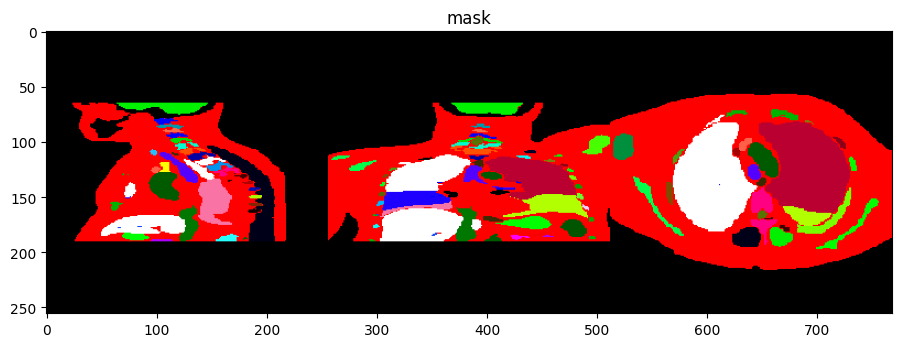

IndexError: index 128 is out of bounds for dimension 3 with size 128

In [27]:
synthetic_labels = model.get_label_tensor(combine_label_tensor=combine_label_or.to(device).float()).clone()#
#synthetic_labels = binarize_labels(synthetic_labels.as_tensor().long())
# synthetic_labels = filter_mask_with_organs(synthetic_labels, ldm_sampler.anatomy_list)
target_class_index = 1
# synthetic_labels[synthetic_labels != target_class_index] = 0
center_loc_axis = find_label_center_loc(torch.flip(filter_mask_with_organs(synthetic_labels, ldm_sampler.anatomy_list).squeeze(0)[0, ...] == target_class_index, [-3, -2, -1]))
colorize = torch.clip(torch.cat([torch.zeros(3, 1, 1, 1), torch.randn(3, 200, 1, 1)], 1), 0, 1)
colorize[:,1,0,0] = torch.ones(3)
synthetic_labels = synthetic_labels.squeeze(0)
vis_mask = get_xyz_plot(
    synthetic_labels.cpu(), center_loc_axis, mask_bool=True, n_label=201, colorize=colorize, target_class_index=target_class_index
)
show_image(vis_mask, title="mask")




image_volume = torch.clip(img, -1000, 300)
image_volume = image_volume - torch.min(image_volume)
image_volume = image_volume / torch.max(image_volume)

vis_image = get_xyz_plot(image_volume, center_loc_axis, mask_bool=False)
show_image(vis_image, title="sample")

with torch.no_grad():
    image_volume = torch.clip(subject_model(img.to(device)).cpu(), -1000, 300)
image_volume = image_volume - torch.min(image_volume)
image_volume = image_volume / torch.max(image_volume)

vis_image = get_xyz_plot(image_volume, center_loc_axis, mask_bool=False)
show_image(vis_image, title="blurred sample")
# create a random color map for mask visualization
# find center voxel location for 2D slice visualization
# center_loc_axis = find_label_center_loc(torch.flip(mask_volume[0, ...] == target_class_index, [-3, -2, -1]))

# visualization
vis_mask = get_xyz_plot(
    mask_volume, center_loc_axis, mask_bool=True, n_label=201, colorize=colorize, target_class_index=target_class_index
)
show_image(vis_mask, title="mask")

image_volume = torch.clip(image_volume_original, -1000, 300)
image_volume = image_volume - torch.min(image_volume)
image_volume = image_volume / torch.max(image_volume)

vis_image = get_xyz_plot(image_volume, center_loc_axis, mask_bool=False)
show_image(vis_image, title="image")

print(image_volume_blurred.min(), image_volume_blurred.max())
image_volume = torch.clip(image_volume_blurred, -1000, 300)
image_volume = image_volume - torch.min(image_volume)
image_volume = image_volume / torch.max(image_volume)

vis_image = get_xyz_plot(image_volume, center_loc_axis, mask_bool=False)
show_image(vis_image, title="blurred")

In [21]:
output_filenames = ldm_sampler.sample_multiple_images(args.num_output_samples)

INFO: Resample mask file to get desired output size and spacing
INFO: Resampling mask to target shape and spacing
INFO: Resize Spacing: [tensor(1.5527, dtype=torch.float64), tensor(1.5527, dtype=torch.float64), tensor(1.5156, dtype=torch.float64)] -> [1.5, 1.5, 4.0]
INFO: Output size: [256, 256, 384] -> [256, 256, 128]
INFO: Resampling mask to target shape and spacing
INFO: Resize Spacing: [tensor(1.5469, dtype=torch.float64), tensor(1.5469, dtype=torch.float64), tensor(1.6211, dtype=torch.float64)] -> [1.5, 1.5, 4.0]
INFO: Output size: [256, 256, 384] -> [256, 256, 128]
INFO: Resampling mask to target shape and spacing
INFO: Resize Spacing: [tensor(1.7987, dtype=torch.float64), tensor(1.2948, dtype=torch.float64), tensor(1.3047, dtype=torch.float64)] -> [1.5, 1.5, 4.0]
INFO: Output size: [256, 256, 384] -> [256, 256, 128]
INFO: Resampling mask to target shape and spacing
INFO: Resize Spacing: [tensor(1.4121, dtype=torch.float64), tensor(1.4121, dtype=torch.float64), tensor(1.5527, dty

augmenting body


  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_2495532/3119852354.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
100%|██████████| 30/30 [00:03<00:00,  9.93it/s]
INFO: ---- DM/ControlNet Latent features generation time: 3.027677059173584 seconds ----
INFO: ---- Start decoding latent features into images... ----
100%|██████████| 4/4 [00:05<00:00,  1.27s/it]
INFO: ---- Image VAE decoding time: 5.084139585494995 seconds ----


1 5
2025-08-25 14:10:53,747 INFO image_writer.py:197 - writing: output/sample_20250825_141053_745562_image.nii.gz
2025-08-25 14:10:54,372 INFO image_writer.py:197 - writing: output/sample_20250825_141053_745562_label.nii.gz


[None, None, None]


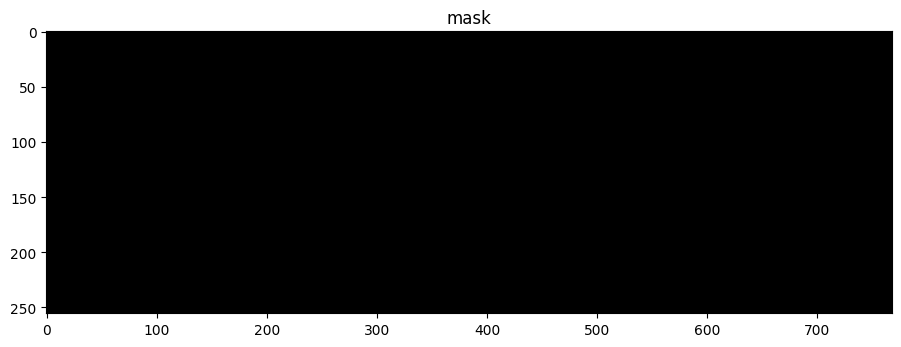

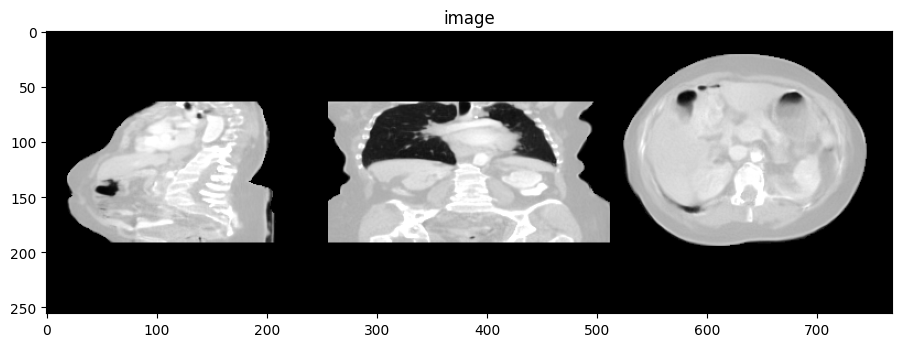

In [22]:
visualize_image_filename = output_filenames[0][0]
visualize_mask_filename = output_filenames[0][1]

# load image/mask pairs
loader = LoadImage(image_only=True, ensure_channel_first=True)
orientation = Orientation(axcodes="RAS")
image_volume = orientation(loader(visualize_image_filename))
mask_volume = orientation(loader(visualize_mask_filename)).to(torch.uint8)

# visualize for CT HU intensity between [-200, 500]
image_volume = torch.clip(image_volume, -1000, 300)
image_volume = image_volume - torch.min(image_volume)
image_volume = image_volume / torch.max(image_volume)

# create a random color map for mask visualization
colorize = torch.clip(torch.cat([torch.zeros(3, 1, 1, 1), torch.randn(3, 200, 1, 1)], 1), 0, 1)
target_class_index = 1

# find center voxel location for 2D slice visualization
center_loc_axis = find_label_center_loc(torch.flip(mask_volume[0, ...] == target_class_index, [-3, -2, -1]))
print(center_loc_axis)
# visualization
vis_mask = get_xyz_plot(
    mask_volume, center_loc_axis, mask_bool=True, n_label=201, colorize=colorize, target_class_index=target_class_index
)
show_image(vis_mask, title="mask")

vis_image = get_xyz_plot(image_volume, center_loc_axis, mask_bool=False)
show_image(vis_image, title="image")